<a href="https://colab.research.google.com/github/ksnugroho/feel-in/blob/main/model-baseline-bilstm/06_Word2Vec_ID_Tweet300_BiGRUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word2Vec (ID Tweet) + Bidirectional GRU**

**Thesis: Emotion Detection in Indonesian Text**

Kuncahyo Setyo Nugroho<br>
Supervisor:
1. Dr. Eng. Fitra A. Bachtiar, S.T., M.Eng.
2. Prof. Ir. Wayan Firdaus Mahmudy, S.Si., M.T., Ph.D.

Faculty of Computer Science, Brawijaya University, Indonesia &copy; 2021-2022

# 01 Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Path to google drive folder
%cd /content/drive/MyDrive/Code/tesis

/content/drive/MyDrive/Code/tesis


In [3]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

SEED = 50
MODEL = 'id-tweet-word2vec-bigru'
FOLDER_PATH = 'model-baseline-bilstm'

np.random.seed(SEED)
tf.random.set_seed(SEED)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [4]:
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 67.9 MB/s 
     |████████████████████████████████| 147 kB 84.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key='bd42e3aab9cac21a2416900b1114532802619de3')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
TODAY = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M")
print(TODAY)

07-15-2022-17:52


# 02 Load Data

In [7]:
df = pd.read_csv('data/final-tweet-anotasi.csv', index_col=0)
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)   # For shuffle
print(df.head())

                                               tweet    label
0        wah belom liat muka gue lagi murka hahahaha      joy
1  Mungkin kurang piknik adrenalin. Mereka yg ske...    anger
2  maaf kalo tersinggung "orang kurus cepet mati"...    anger
3  berserah pada maha esa paling tabah dan sabar ...      joy
4                       Ehekk malu la hahahahahahaha  sadness


In [8]:
# df = df.dropna()

In [9]:
df.shape

(2243, 2)

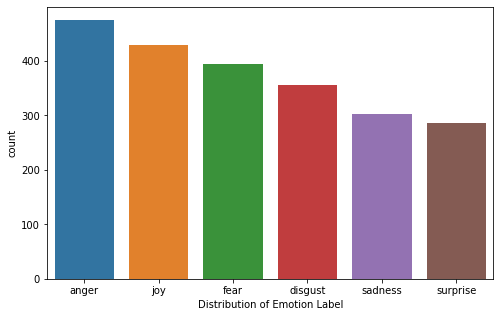

anger       475
disgust     355
fear        395
joy         429
sadness     303
surprise    286
Name: label, dtype: int64

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xlabel('Distribution of Emotion Label')
plt.show()

df['label'].value_counts().sort_index()

# 03 Preprocessing

## Text Cleaning

In [11]:
def text_cleaning(text):
    text = text.lower()                               # Mengubah teks menjadi lower case
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
    text = re.sub(r'\s+', ' ', text).strip()          # Menghapus whitespaces

    return text

In [12]:
%%time 
df['tweet'] = df['tweet'].progress_apply(text_cleaning)

100%|██████████| 2243/2243 [00:00<00:00, 53618.05it/s]

CPU times: user 46 ms, sys: 2.83 ms, total: 48.8 ms
Wall time: 47.6 ms


## Label Encoder

In [13]:
le = LabelEncoder()

df['label_encode'] = le.fit_transform(df['label'])
print(df.head())

                                               tweet    label  label_encode
0        wah belom liat muka gue lagi murka hahahaha      joy             3
1  mungkin kurang piknik adrenalin mereka yg skep...    anger             0
2  maaf kalo tersinggung orang kurus cepet mati w...    anger             0
3  berserah pada maha esa paling tabah dan sabar ...      joy             3
4                       ehekk malu la hahahahahahaha  sadness             4


In [14]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [15]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


# 04 Load Pre-Trained Word Vectors (Word2Vec)

In [16]:
%%time
WORD_EMBEDDING_PATH = 'model-word-embedding/checkpoint/idtweet-word2vec/idtweet-word2vec-300.wordvectors'

word2vec = KeyedVectors.load(WORD_EMBEDDING_PATH,  mmap='r')
vocabulary = word2vec.wv.vocab     # gensim 3
# vocabulary = word2vec.index_to_key # gensim 4
print('The numbers of words in vocabulary: ', len(vocabulary))

VOCAB_SIZE = len(vocabulary)
EMBEDDING_SIZE = word2vec.vector_size

The numbers of words in vocabulary:  156312
CPU times: user 354 ms, sys: 55.9 ms, total: 410 ms
Wall time: 1.22 s


In [17]:
word2vec_dict = {}

for word in vocabulary:
    word2vec_dict[word] = word2vec.wv.get_vector(word)   # gensim 3
    # word2vec_dict[word] = word2vec.get_vector(word)
    
print('The numbers of key-value pairs: ', len(word2vec_dict)) # should come equal to vocab size

The numbers of key-value pairs:  156312


In [18]:
# Cek vektor embedding dan dimensi dari suatu kata
word = 'saya'

print(word2vec[word])
print('Embedding size: ', word2vec[word].shape)

[-0.00196746  0.09941631 -0.15455686  0.3142614   0.41066077 -0.03517361
  0.26521245 -0.03657137  0.3173049  -0.18076545 -0.21691021 -0.09863748
  0.05417929  0.05028491  0.20421515  0.47201592 -0.07448783 -0.19730976
  0.23256293 -0.3501546   0.29862374 -0.08062083  0.1474152   0.16452017
  0.08921923 -0.0515116  -0.02296514  0.03125457  0.21018551  0.17645973
 -0.42446497  0.14217879  0.12172476  0.14507127  0.02638973  0.0277294
 -0.05690918  0.15437318 -0.11035231 -0.11839799 -0.29085988 -0.01823551
 -0.17403328 -0.27379602  0.55877054 -0.26623386  0.23594622  0.01485427
 -0.13379507  0.31024277 -0.09457285 -0.16680506 -0.09147608  0.07846192
 -0.06219688  0.36456916  0.1809628   0.00432387 -0.1508676  -0.02532905
  0.210815   -0.05091454  0.20892504  0.14765981  0.13505444  0.18222973
 -0.24667571  0.14310431 -0.5898385   0.188767   -0.2937882  -0.16072911
 -0.02532982  0.18123326  0.09687859 -0.30978984  0.23164721  0.02654802
 -0.00515777 -0.09863718 -0.28871697 -0.17984474 -0.

# 05 Choosing Maximum Length of the Sequence  

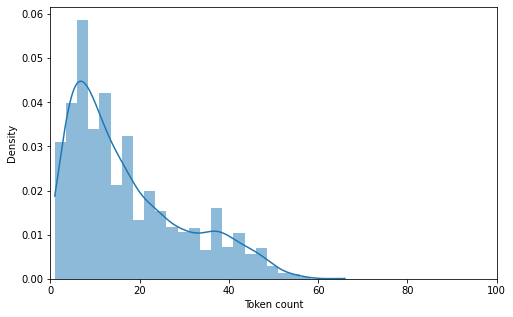

In [19]:
token_lens = []

for text in df['tweet']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [20]:
MAX_SEQ_LENGTH = 80

# 06 Preparing Data for Embedding Layer

## Tokenizing Data

In [21]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(df['tweet'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

8831


## Text To Sequence

In [22]:
# Proses mengubah token menjadi urutan bilangan int berdasarkan dictionary.
data_seq = tokenizer.texts_to_sequences(df['tweet'])

In [23]:
print(df['tweet'][10])
print(data_seq[10])

apalagi yg jualan spotify premium banyak banget lamalama bikin risih
[1, 3, 1, 1, 1, 62, 31, 1, 56, 50]


## Add padding & Truncation

In [24]:
# Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
PADDING = 'post'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'post'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [25]:
print(df['tweet'][10])
print(data_seq[10])
print(data_pad[10])

apalagi yg jualan spotify premium banyak banget lamalama bikin risih
[1, 3, 1, 1, 1, 62, 31, 1, 56, 50]
[ 1  3  1  1  1 62 31  1 56 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [26]:
data_pad.shape

(2243, 80)

## Create Embedding Matrix

In [27]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
    embed_vector = word2vec_dict.get(word)
    if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
        EMBEDDING_MATRIX[i] = embed_vector

In [28]:
print(WV_DICTIONARY.get('saya'))

33


In [29]:
print(EMBEDDING_MATRIX[33])

[-0.00196746  0.09941631 -0.15455686  0.31426141  0.41066077 -0.03517361
  0.26521245 -0.03657137  0.31730491 -0.18076545 -0.21691021 -0.09863748
  0.05417929  0.05028491  0.20421515  0.47201592 -0.07448783 -0.19730976
  0.23256293 -0.35015461  0.29862374 -0.08062083  0.14741521  0.16452017
  0.08921923 -0.0515116  -0.02296514  0.03125457  0.21018551  0.17645973
 -0.42446497  0.14217879  0.12172476  0.14507127  0.02638973  0.0277294
 -0.05690918  0.15437318 -0.11035231 -0.11839799 -0.29085988 -0.01823551
 -0.17403328 -0.27379602  0.55877054 -0.26623386  0.23594622  0.01485427
 -0.13379507  0.31024277 -0.09457285 -0.16680506 -0.09147608  0.07846192
 -0.06219688  0.36456916  0.1809628   0.00432387 -0.1508676  -0.02532905
  0.210815   -0.05091454  0.20892504  0.14765981  0.13505444  0.18222973
 -0.24667571  0.14310431 -0.5898385   0.188767   -0.29378819 -0.16072911
 -0.02532982  0.18123326  0.09687859 -0.30978984  0.23164721  0.02654802
 -0.00515777 -0.09863718 -0.28871697 -0.17984474 -0.

In [30]:
EMBEDDING_MATRIX.shape

(8831, 300)

# 07 Train & Test Data Splitting

In [31]:
NUM_CLASS = len(df['label_encode'].unique())

Y = to_categorical(df['label_encode'], num_classes=NUM_CLASS)  # Lakukan one-hot encoding pada label (y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_pad, Y, test_size=0.20, stratify=Y, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1794, 80), (449, 80), (1794, 6), (449, 6))

# 08 Define Model (Bidirectional GRU)

## Architecture

In [33]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

UNITS = 64

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,                                
    output_dim = EMBEDDING_SIZE,                           
    input_length = MAX_SEQ_LENGTH,  
    trainable = False,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(Bidirectional(GRU(UNITS*2, dropout=0.5, return_sequences=False)))
model.add(Dense(UNITS, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 300)           2649300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,996,378
Trainable params: 347,078
Non-trainable params: 2,649,300
________________________________________

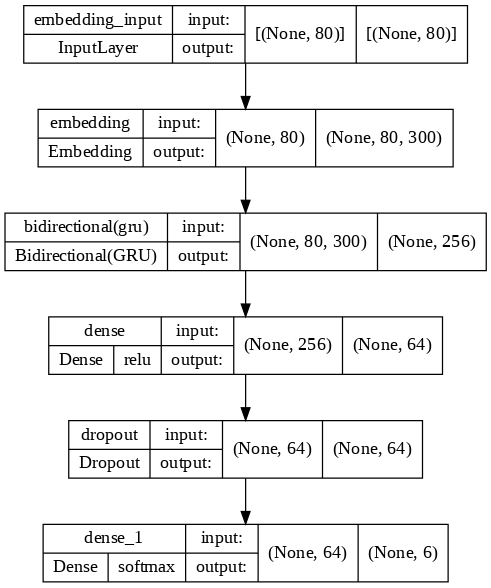

In [35]:
plot_model(model, show_shapes=True, show_layer_activations=True, show_dtype=False, dpi=90, to_file=f'{FOLDER_PATH}/model-plot/{MODEL}-model.png')

## Compile

In [36]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics

METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
]

LEARNING_RATE = 0.001

In [37]:
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)

# 09 Early Stopping & Model Checkpoint

In [38]:
# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

# Path to model checkpoint
checkpoint_dir = f'{FOLDER_PATH}/model-checkpoint/{MODEL}/cp.ckpt'
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', save_weights_only=True, verbose=1, save_freq='epoch', save_best_only=True)

In [39]:
# Path to model log
log_dir = f'{FOLDER_PATH}/model-log/{MODEL}/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
print(log_dir)

model-baseline-bilstm/model-log/id-tweet-word2vec-bigru/20220715-175227


In [40]:
tensorboard_callback = TensorBoard(log_dir=log_dir ,update_freq='epoch', histogram_freq=1, embeddings_freq=1)

# 10 Training

In [41]:
EPOCHS = 10
BATCH_SIZE = 16

# Config for wandb
config = {
    'type': 'baseline',
    'architecture': 'BiGRU',
    'word_embedding': 'Word2Vec-ID-tweet-300',
    'dataset': 'indo-tweet-emotion',
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'loss_function': LOSS_FUNCTION.name,
    'optimizer': OPTIMIZER._name
}

In [42]:
%%time

# Initialize wandb 
wandb.tensorboard.patch(root_logdir=log_dir)
wandb_run = wandb.init(project='baseline-bilstm', name=f'{MODEL}', entity='indoemobert', config=config, sync_tensorboard=True)

# Training
model_history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test, y_test), 
    verbose=1, 
    steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
    callbacks=[
        # early_stopping, 
        model_checkpoint,
        tensorboard_callback,
        WandbCallback(
            input_type='text',
            training_data=(X_train, y_train),
            validation_data=(X_test, y_test),
            labels=LABEL_NAME,
            monitor='val_loss',
            log_best_prefix='best_',
            log_gradients=True,
            log_weights=True,
            save_weights_only=True,
            save_model=False
        )]
)

wandb_run.finish()

wandb: Currently logged in as: indoemobert. Use `wandb login --relogin` to force relogin


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/10
113/113 [==============================] - ETA: 0s - loss: 1.6291 - accuracy: 0.3250 - precision: 0.8476 - recall: 0.0496
Epoch 1: val_accuracy improved from -inf to 0.58352, saving model to model-baseline-bilstm/model-checkpoint/id-tweet-word2vec-bigru/cp.ckpt
113/113 [==============================] - 16s 69ms/step - loss: 1.6291 - accuracy: 0.3250 - precision: 0.8476 - recall: 0.0496 - val_loss: 1.2013 - val_accuracy: 0.5835 - val_precision: 0.9310 - val_recall: 0.2405 - _timestamp: 1657907572.0000 - _runtime: 22.0000
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 1.1308 - accuracy: 0.5987 - precision: 0.8237 - recall: 0.3802
Epoch 2: val_accuracy improved from 0.58352 to 0.75947, saving model to model-baseline-bilstm/model-checkpoint/id-tweet-word2vec-bigru/cp.ckpt
113/113 [==============================] - 3s 29ms/step - loss: 1.1308 - accuracy: 0.5987 - preci

accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▁▁▁▁▁
precision,▅▁▁▄▅▇▇▆█▇
recall,▁▄▇▇██████
val_accuracy,▁▆█▇██████
val_loss,█▃▁▁▁▁▁▁▁▁
val_precision,█▁▃▁▃▁▂▂▂▃
val_recall,▁▅▇███████
GFLOPS,4e-05
accuracy,0.81382


CPU times: user 53.6 s, sys: 5.79 s, total: 59.4 s
Wall time: 1min 1s


In [43]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace('_',' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend(loc='lower right');

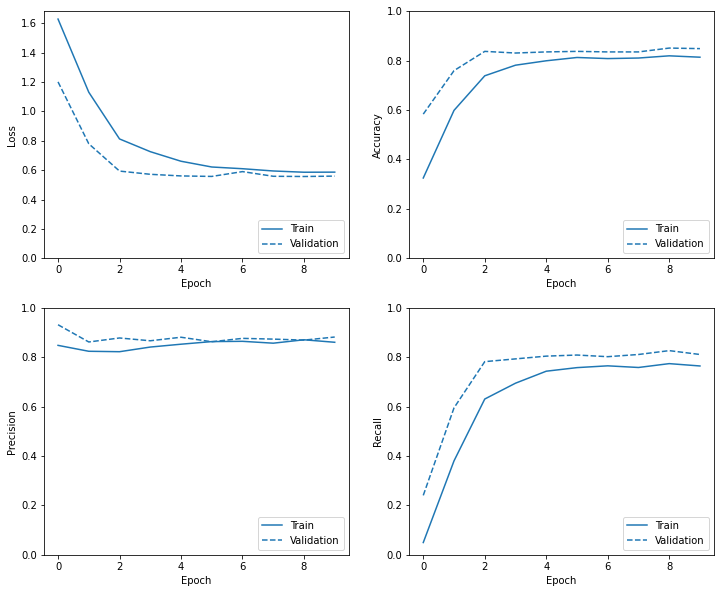

In [44]:
plot_metrics(model_history)

In [45]:
hist_df = pd.DataFrame(model_history.history)
print(hist_df)

hist_df.to_csv(f'{FOLDER_PATH}/model-history/{MODEL}-{TODAY}.csv')

       loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  1.629077  0.324972   0.847619  0.049610  1.201259      0.583519   
1  1.130838  0.598662   0.823672  0.380156  0.779817      0.759465   
2  0.812782  0.738573   0.821948  0.630435  0.593890      0.837416   
3  0.726155  0.781494   0.840756  0.694537  0.571990      0.830735   
4  0.660911  0.799331   0.852302  0.743032  0.560895      0.835189   
5  0.621687  0.812709   0.862857  0.757525  0.557489      0.837416   
6  0.610001  0.808250   0.863980  0.764771  0.590269      0.835189   
7  0.594590  0.810479   0.856423  0.758083  0.558497      0.835189   
8  0.586062  0.819398   0.870219  0.773690  0.556980      0.850780   
9  0.586685  0.813824   0.860100  0.764214  0.559674      0.848552   

   val_precision  val_recall  _timestamp  _runtime  
0       0.931035    0.240535  1657907572        22  
1       0.861290    0.594655  1657907575        25  
2       0.877500    0.781737  1657907578        28  
3       0.866180 

In [46]:
# save model
model.save(f'{FOLDER_PATH}/model-fit/{MODEL}/{MODEL}.h5')

# 11 Evaluation

In [47]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy*100))

15/15 [==============================] - 0s 9ms/step - loss: 0.5597 - accuracy: 0.8486 - precision: 0.8814 - recall: 0.8107
Accuracy: 84.86%


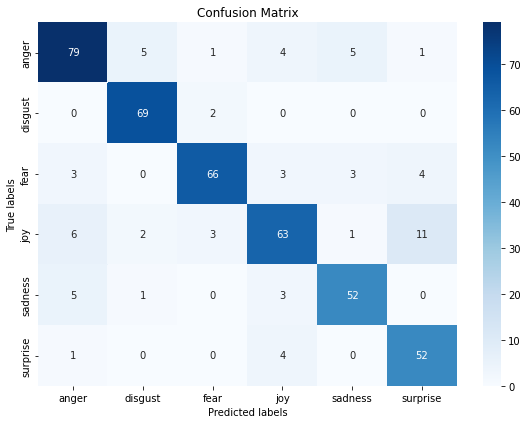

In [48]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  # annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(LABEL_NAME)
ax.yaxis.set_ticklabels(LABEL_NAME)
plt.tight_layout()

In [49]:
print(classification_report(y_pred, y_true, target_names=LABEL_NAME))

              precision    recall  f1-score   support

       anger       0.83      0.84      0.84        94
     disgust       0.97      0.90      0.93        77
        fear       0.84      0.92      0.87        72
         joy       0.73      0.82      0.77        77
     sadness       0.85      0.85      0.85        61
    surprise       0.91      0.76      0.83        68

    accuracy                           0.85       449
   macro avg       0.86      0.85      0.85       449
weighted avg       0.85      0.85      0.85       449



In [50]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(len(LABEL_NAME)))
  y_pred = label_binarize(y_pred, classes=np.arange(len(LABEL_NAME)))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  # Plot all ROC curves
  plt.figure(figsize=(10, 7))
  lw = 2
  plt.plot(fpr['micro'], tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink', linestyle=':', linewidth=4,)

  plt.plot(fpr['macro'], tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy', linestyle=':', linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'darkgreen', 'yellow', 'blue', 'red'])
  for i, color, label in zip(range(n_classes), colors, LABEL_NAME):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) curve')
  plt.legend()
  plt.show()

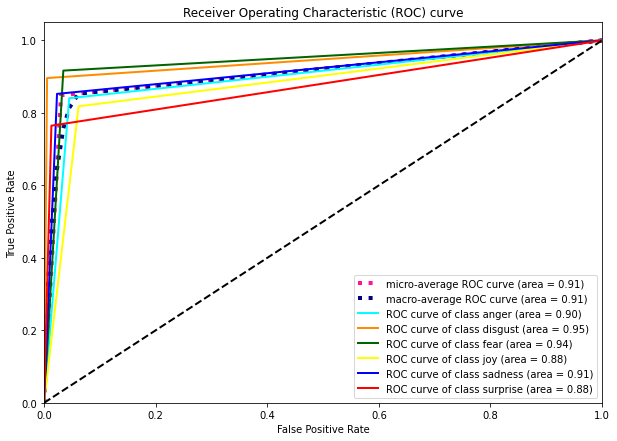

In [51]:
plot_roc_curve(y_pred, y_true)

# 12 Predict on New Data

In [52]:
new_text = ['Hargai kebahagiaan jika kamu pernah sedih']

text_seq = tokenizer.texts_to_sequences(new_text,)
text_padded = pad_sequences(text_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

pred = model.predict(text_padded)

print(pred, LABEL_NAME[np.argmax(pred, axis=1)])

[[0.1032793  0.00094672 0.00389855 0.04947125 0.8404431  0.00196113]] ['sadness']
